In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

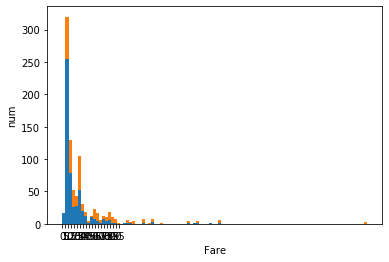

In [3]:
plt.xlabel("Fare")
plt.ylabel("num")
split_data = []
for survived in [0,1]:
    split_data.append(train_df[train_df.Survived==survived])

temp = [i["Fare"].dropna() for i in split_data]
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.hist(temp, histtype="barstacked",bins=100)

# plt.savefig('Fare-hist.png')

plt.xticks(range(0, 100,5))
plt.show()

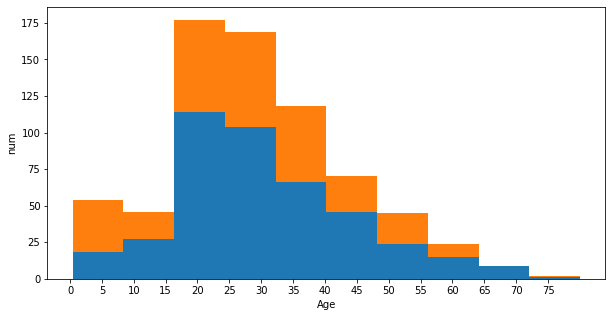

In [4]:
plt.xlabel("Age")
plt.ylabel("num")
split_data = []
for survived in [0,1]:
    split_data.append(train_df[train_df.Survived==survived])

temp = [i["Age"].dropna() for i in split_data]
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.hist(temp, histtype="barstacked")

plt.savefig('Age-hist2.png')

plt.xticks(range(0, 80,5))
plt.show()

In [5]:
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

guess_ages = np.zeros((2,3))
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
train_df = train_df.drop(['Name', 'PassengerId','Parch', 'SibSp'], axis=1)
test_df = test_df.drop(['Name','Parch', 'SibSp'], axis=1)
combine = [train_df, test_df]

for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 10, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 10) & (dataset['Age'] <= 20), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 20) & (dataset['Age'] <= 50), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 50) & (dataset['Age'] <= 70), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 70, 'Age'] = 4

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,0,3,0,2,0,0,1,2
1,1,1,1,2,3,1,3,2
2,1,3,1,2,1,0,2,1
3,1,1,1,2,3,0,3,2
4,0,3,0,2,1,0,1,1


In [6]:
# test_df.isnull().sum()
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape


# random_forest = RandomForestClassifier(n_estimators=100,max_features=3,min_samples_leaf=50,max_depth=100)
random_forest = RandomForestClassifier(n_estimators=100,oob_score = True, n_jobs = -1,random_state = 50,max_features = "auto",min_samples_leaf = 50)
# random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

79.69

In [7]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': Y_pred})
output.to_csv('my_submission8.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
